# Project 1

ECE 7995_1801_003: Detection and Estimation 
Submitted By: Prabhjot Kaur

Implement face detection and recognition methods, called Eigenfaces. 
Refrence papers: https://vision.cornell.edu/se3/wp-content/uploads/2014/09/eccv96.pdf and http://www.scholarpedia.org/article/Eigenfaces

#PART I: Face detection
As the name suggests, Eigenfaces models the properties of face images via the eigenvectors of the data matrix. 
In this part you will build a face *detector*, which will determine whether an image is of a face or of something else.
We'll build and test the detector using the Olivetti faces dataset and the MNIST digits dataset that you've worked with before.

In [1]:
import numpy as np
from scipy import linalg
from skimage import transform as tf
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_olivetti_faces

import matplotlib.pyplot as plt

In [2]:
# 1) Download the Olivetti and MNIST datasets. You will need to resize the MNIST images to be 64x64; you can use scipy.misc.imresize() for this. 
#    Partition each dataset into TWO halves each: one for training, and one for testing.

#Digits dataset
digits = load_digits()
train_digits_img = []
train_digits_labels = []
test_digits_img = []
test_digits_labels = []
for i in range(0,10):
    index = digits.target==i
    img = digits.images[index]
    label = digits.target[index]
    for j in range(0,int(np.ceil(len(label)/2))):
        im_resized = tf.resize(img[j],(64,64))
        train_digits_img.append(im_resized)
        train_digits_labels.append(label[j])
    for k in range(int(np.ceil(len(label)/2)), len(label)):
        im_resized = tf.resize(img[j],(64,64))
        test_digits_img.append(im_resized)
        test_digits_labels.append(label[k]) 
#plt.gray() 
#plt.matshow(train_digits_img[800]) 
#plt.show() 
#print("This image belongs to class", train_digits_labels[800])


#Faces dataset
faces = fetch_olivetti_faces()
train_faces_img = []
train_faces_labels = []
test_faces_img = []
test_faces_labels = []
for i in range(0,40):
    index = faces.target==i
    img = faces.images[index]
    label = faces.target[index]
    for j in range(0,int(np.ceil(len(label)/2))):
        train_faces_img.append(img[j])
        train_faces_labels.append(label[j])
    for k in range(int(np.ceil(len(label)/2)), len(label)):
        test_faces_img.append(img[k])
        test_faces_labels.append(label[k])      
#plt.gray() 
#plt.matshow(train_faces_img[150]) 
#plt.show() 
#print("This image belongs to class", train_faces_labels[150])



C:\Users\kaurp\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [3]:
# 2) Using the training datasets, compute the mean for the face and digits datasets, denoted m_0 and m_1, respectively. 
#    Next, compute the empirical *covariance* matrix of each class, denoted K_0 and K_1; 
#    treating each image as a column vector x, the empirical covariance is found by averaging (x - m_i)*(x-m_i)^T for each class.

m_0 = np.reshape(np.mean(train_faces_img,0),(4096,1))
m_1 = np.reshape(np.mean(train_digits_img,0),(4096,1))
m_1 = np.reshape(m_1,(4096,1))

#covarinace of faces training class
x = np.resize(train_faces_img,(len(train_faces_img),(4096)))
v = x.T-m_0
K_0 = (v@v.T)/len(train_faces_img)

#covarinace of digits training class
x = np.resize(train_digits_img,(len(train_digits_img),(4096)))
v = x.T-m_1
K_1 = (v@v.T)/len(train_digits_img)


In [4]:
# 3) Eigenfaces uses the PCA method to model the images. Take the eigenvector-eigenvalue decomposition of each matrix, 
#    and let U_0 and U_1 denote the matrix of the top 10 eigenvectors of K_0 and K_1, respectively. 
#    Make sure that the columns are of unit norm, so that they form an orthonormal set.

eVal_0,eVec_0 = np.linalg.eig(K_0)
U_0 = eVec_0[:,0:10]

eVal_1,eVec_1 = np.linalg.eig(K_1)
U_1 = eVec_1[:,0:10] #4096x10

#print(eVal_0[0:10])
#print(eVal_1[0:10])

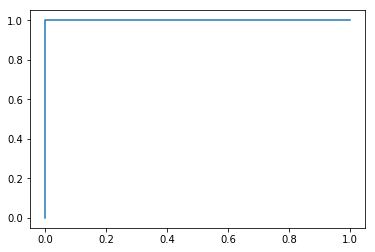

In [5]:
# 4) Your face detector will use the likelihoods p(y|H0) = N(mu_0, U_0*U_0^T + sigma^2*I) and  p(y|H1) = N(mu_1, U_1*U_1^T + sigma^2*I).
#   Derive the Neyman-Pearson detector for this problem using these likelihood functions for sigma^2 of your choice. 
#   Empirically compute the ROC curve by drawing 1000 samples from each distribution and computing P_FA and P_D.
sample_size = 1000
sigma_2 = 10

cov_0 = U_0@(U_0.T) + sigma_2*np.eye(4096) #faces dataset
cov_1 = U_1@(U_1.T) + sigma_2*np.eye(4096) #digits dataset
#(sign, logdet) = np.linalg.slogdet(cov_0)
#(sign1, logdet1) = np.linalg.slogdet(cov_1)
#print(logdet)
#print(logdet1)

cov0_inv = np.linalg.inv(cov_0) 
cov1_inv = np.linalg.inv(cov_1)
a1 = (m_1.T)@cov1_inv - (m_0.T)@cov0_inv   #1x4096
a2 = 0.5*(cov0_inv - cov1_inv)      #4096x4096
constant = 0.5*(m_1.T@cov1_inv@m_1 - m_0.T@cov0_inv@m_0)

nu = np.arange(-10000,10000,100)
Pfa_H0 = np.zeros(nu.size)    
Pd_H1 = np.zeros(nu.size)

mu_0 = np.reshape(m_0,(64,64))
mu_1 = np.reshape(m_1,(64,64))

for j in range(0, nu.size):
    threshold = nu[j]+constant
    for k in range(0, sample_size):
        #y_0 = np.random.multivariate_normal(m_0,cov_0)
        y_0 = mu_0 + np.sqrt(sigma_2)*np.random.randn(64,64)
        y_0 = np.reshape(y_0,(4096,1))
        compare_0 =  a1@y_0 + (y_0.T)@a2@y_0
        if compare_0 > threshold:
            Pfa_H0[j] += 1/sample_size
            
    for l in range(0, sample_size):
        #y_1 = np.random.multivariate_normal(m_1,cov_1)
        y_1 = mu_1 + np.sqrt(sigma_2)*np.random.randn(64,64)
        y_1 = np.reshape(y_1,(4096,1))
        compare_1 =  a1@y_1 + (y_1.T)@a2@y_1
        if compare_1 > threshold:
            Pd_H1[j] += 1/sample_size        

plt.plot(Pfa_H0,Pd_H1)
plt.show()
      

*** Please Note *** The above code was ran for 100 samples only due to the long time it takes to run for more samples.

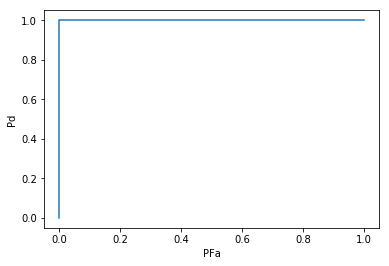

In [6]:
# 5) Now, use the *test* set to compute the ROC curve on real-world data. 
#    For each threshold, compute the empirical probability of false alarm and missed detection over the test images. 
#    Is this ROC curve the same as the one you computed in (4)? Why or why not?

nu = np.arange(-10000,10000,100)
Pfa = np.zeros(nu.size)    
Pd = np.zeros(nu.size)

for j in range(0, nu.size):
    threshold = nu[j]+constant
    for k in range(0, len(test_faces_img)):
        #y_0 = np.random.multivariate_normal(m_0,cov_0)
        y_0 = test_faces_img[k]     
        y_0 = np.reshape(y_0,(4096,1))
        compare_0 =  a1@y_0 + (y_0.T)@a2@y_0
        if compare_0 > threshold:
            Pfa[j] += 1/len(test_faces_img)
                 
    for l in range(0, len(test_digits_img)):
        #y_1 = np.random.multivariate_normal(m_1,cov_1)
        y_1 = test_digits_img[k]
        y_1 = np.reshape(y_1,(4096,1))
        compare_1 =  a1@y_1 + (y_1.T)@a2@y_1
        if compare_1 > threshold:
            Pd[j] += 1/len(test_digits_img)

plt.plot(Pfa,Pd)
plt.xlabel('PFa')
plt.ylabel('Pd')
plt.show()


In [10]:
print(Pd)
print(Pfa)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 0.995 0.905 0.84  0.5   0.16  0.03  0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0. 

In my case, the curves in Question 4 and 5 are almost identical, indicating that it is a good detector. However, I had anticipated the ROC curve in question 5 to be less concave (steeper - indicating higher probability of error) because the detector in question 5 is based on the mean and covaraince derived from the training set and is being tested on the test set.

PART II: Face recognition
In this part you will build a face classifier, which will tell *of whose face* an image is. 
In this case, we will use only the faces dataset. Define U = U_0 as computed in the previous problem.


In [11]:
# 1) Compute the mean of each *class*, where each individual has her/his own class. Denote these means m_i.

m_i = np.zeros((40,4096)) # to store mean of forty classes as row vectors
#learn the mean for each of the 40 classes. This mean is solely derived from the training set
for ID in range(0,40):
    index = np.asarray(train_faces_labels)== ID
    indices = np.asarray(np.where(index))[0,:]
    images = [train_faces_img[i] for i in indices]
    mu = np.mean(images,0)
    m_i[ID,:] = np.reshape(mu,-1)  
           

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


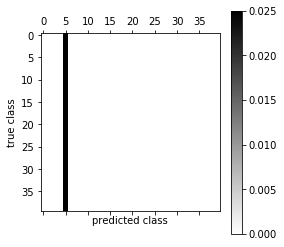

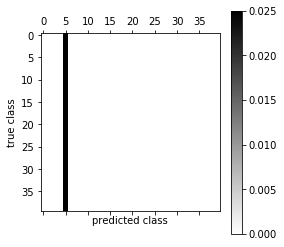

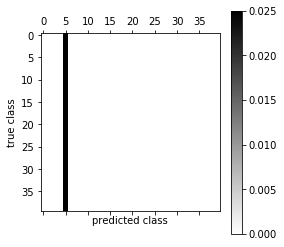

In [12]:
# 2) The classifier will use p(y|Hi) = N(m_i, U*U^T + sigma^2*I) as the likelihood functions. 
#    Determine the maximum-likelihood classifier in terms of m_i, sigma^2, and U. 
#    Specifically, find an explicit expression for the inverse of the covariance U*U^T + sigma^2*I. 
#    For sigma^2 = {1, 10, 100}, determine the *confusion matrix* over the test set, 
#    i.e. the probability that an image of class i is classified as class j.

#Using the folowing test set for testing the maximum likelihood detector
#test_faces_img = []
#test_faces_labels = []

sigma_2 = np.array([1,10,100])
sample_size = len(test_faces_img)
cmpr = 0
maxLikelihood_idx  = 0

for sigma in range(0,sigma_2.size):
    covariance_inv = np.linalg.inv(U_0@(U_0.T) + sigma_2[sigma]*np.eye(4096))
    conf_matrix = np.zeros((40,40)) 
    arg2cmpr = np.zeros((1,40))
    for k in range(0, sample_size):
        y = test_faces_img[k]
        y = np.reshape(y,(4096,1))
        for classes in range (0,40):
            # cmpr = y^T*covarinace_inv*mu_i + mu_i^T*covarinace_inv*y + mu_i^T*covarinace_inv*mu_i
            cmpr = y.T@covariance_inv@m_i[classes,:] + m_i[classes,:].T@covariance_inv@y + m_i[classes,:].T@covariance_inv@m_i[classes,:]
            arg2cmpr[0,classes] = cmpr
    
        #maximum likelihood detector
        maxLikelihood_idx = np.argmax(arg2cmpr)
    
        #Confusion matrix
        conf_matrix[test_faces_labels[k],maxLikelihood_idx] = conf_matrix[test_faces_labels[k],maxLikelihood_idx] +1

    normalized_confmtrx = conf_matrix/sample_size
    print(normalized_confmtrx)
    
    plt.figure(figsize=(10,10))
    plt.matshow(normalized_confmtrx, cmap=plt.cm.gray_r)
    plt.colorbar()
    tick_marks = np.arange(0,40,5)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.ylabel('true class')
    plt.xlabel('predicted class')





For some reason, the maximum likelihood detector derived above always classifies images as belonging to class 5. Below, I used the code sample from Python Assignment 4 Solutions and got the same result as above.

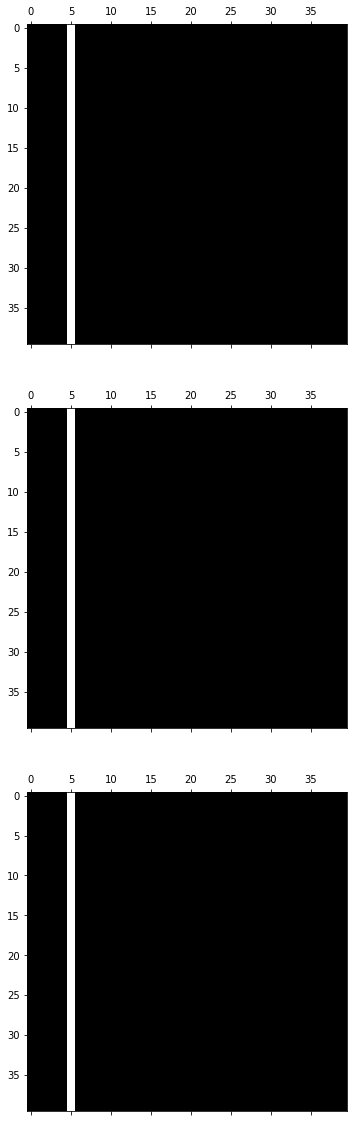

In [255]:
# 2) The classifier will use p(y|Hi) = N(m_i, U*U^T + sigma^2*I) as the likelihood functions. 
#    Determine the maximum-likelihood classifier in terms of m_i, sigma^2, and U. 
#    Specifically, find an explicit expression for the inverse of the covariance U*U^T + sigma^2*I. 
#    For sigma^2 = {1, 10, 100}, determine the *confusion matrix* over the test set, 
#    i.e. the probability that an image of class i is classified as class j.

#Using the folowing test set for testing the maximum likelihood detector
#test_faces_img = []
#test_faces_labels = []

sigma_2s = [1,10,100]
NUM_SAMPLES = len(test_faces_img)
fig, axs = plt.subplots(nrows=len(sigma_2s), figsize=(20, 20))

for j in range(0,len(sigma_2s)):
    sigma_2 = sigma_2s[j]
    C = np.zeros([40,40])
    covariance_inv = np.linalg.inv(U_0@(U_0.T) + sigma_2*np.eye(4096))
    for p in range(0,NUM_SAMPLES):
        y_ = test_faces_img[p]
        y_ = np.reshape(y_,(4096,1))
        norms = np.zeros(40)
        for i in range(0,40):
            norms[i] = y_.T@covariance_inv@m_i[i,:] + m_i[i,:].T@covariance_inv@y_ + m_i[i,:].T@covariance_inv@m_i[i,:]
        H_hat = np.argmax(norms)
        C[test_faces_labels[p],H_hat] += 1/NUM_SAMPLES
    axs[j].matshow(C)

plt.show()

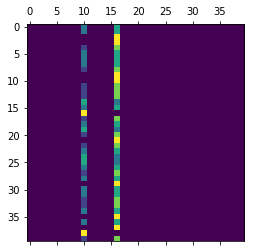

In [13]:
# 3) Determine the form of the classifier in the limit of \sigma^2 -> 0. 
#   Suggest a simple interpetation of this classifier in terms of looking at each image in the "face space" spanned by the columns of U. 
#   This form is the Eigenface detector suggested above; it is an approximation of the statistical classifier that is optimum in the limit of small model noise. 
#   Compute the confusion matrix for this classifier. Is there much change in performance?

#Using the folowing test set for testing the maximum likelihood detector
#test_faces_img = []
#test_faces_labels = []

NUM_SAMPLES = len(test_faces_img)
fig, axs = plt.subplots(nrows=1)

C = np.zeros([40,40])
cov_pinv = np.linalg.pinv(U_0@(U_0.T))  #pseudoinverse
for p in range(0,NUM_SAMPLES):
    y_ = test_faces_img[p]
    y_ = np.reshape(y_,(4096,1))
    norms = np.zeros(40)
    for i in range(0,40):
        norms[i] = y_.T@cov_pinv@m_i[i,:] + m_i[i,:].T@cov_pinv@y_ + m_i[i,:].T@cov_pinv@m_i[i,:]
    H_hat = np.argmax(norms)
    C[test_faces_labels[p],H_hat] += 1/NUM_SAMPLES

axs.matshow(C)

plt.show()




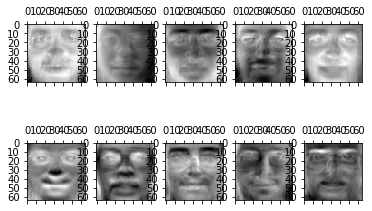

In [262]:
#Plotting the eigenfaces represented by 10 eigenvectors in U_0
fig, axes = plt.subplots(2,5)
for j in range(0,2):
    for i in range(0,5):
        if j == 0:
            eFace = U_0[:,i]
            eigFace = np.reshape(eFace,(64,64))
            axes[j,i].matshow(eigFace)
        elif j ==1:
            eFace = U_0[:,i+5]
            eigFace = np.reshape(eFace,(64,64))
            axes[j,i].matshow(eigFace)

As the limit of sigma_2 -->0, the maximum likelihood classifier reduces to the following:
argmax(i) = y^T*covarinace_inv*mu_i + mu_i^T*covarinace_inv*y + mu_i^T*covarinace_inv*mu_i, where 
covariance_inv = pseudoinverse( U_0*U_0^T) 

According to this classifier, every image is a linear combination of the above 10 eigenfaces.

The performance of this classifier is slightly better than the classifier deriverd in problem 2 but not quite good because it still classifies test images as either belonging to class 10 or 16.